# Compare source discretizations

Here, we will compare a 3D tensor simulation with the 3D cyl code in an FDEM problem. The model is a half-space, and a bipole source is used. One electrode is positioned on the surface and another is positioned within the earth (mimicing many of the casing scenarios we simulate in the paper) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import tarfile

from SimPEG import Mesh, Utils, Maps
from discretize import utils

import casingSimulations as casingSim

%matplotlib inline

In [2]:
sim_dir_cyl = 'compare_3D_cyl_and_tensor_sources_downhole_cyl'
sim_dir_tensor = 'compare_3D_cyl_and_tensor_sources_downhole_cart'

If rerun is `True` we will recompute the results, otherwise, stored results will be downloaded

In [3]:
rerun = False

## Use the casing mesh, no physical property contrasts

In [4]:
sigma_back = 1e-1

cyl_model = casingSim.model.Halfspace(
    sigma_back = sigma_back,
    src_a = np.r_[0., np.pi, -950.],
    src_b = np.r_[1e3, np.pi, 0.],
    freqs = [1.],
)

cart_model = cyl_model.copy()
cart_model.src_a[1] = 0.
cart_model.src_b[1] = 0.
cart_model.src_b[0] *= -1

## Mesh

In [5]:
npadx, npadz = 9, 9
dx2 = 1000. 
csx = 20.
csz = 20.

ncy = 3
nstretchy = 4
stretchfact = 1.6
hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = hy * 2*np.pi/hy.sum()

cyl_mesh_gen = casingSim.CylMeshGenerator(
    modelParameters=cyl_model, 
    npadx=npadx, 
    npadz=npadz, 
    domain_x=dx2, 
    hy=hy, 
    csx=csx, 
    csz=csz
)

In [6]:
cyl_mesh_gen.serialize()

{'__class__': 'CylMeshGenerator',
 'csx': 20.0,
 'csz': 20.0,
 'directory': '.',
 'domain_x': 1000.0,
 'filename': 'MeshParameters.json',
 'hy': [1.2623695010647757,
  0.7889809381654849,
  0.493113086353428,
  0.3081956789708925,
  0.1926222993568078,
  0.1926222993568078,
  0.1926222993568078,
  0.3081956789708925,
  0.493113086353428,
  0.7889809381654849,
  1.2623695010647757],
 'modelParameters': {'__class__': 'Halfspace',
  'directory': '.',
  'filename': 'ModelParameters.json',
  'freqs': [1.0],
  'mur_back': 1.0,
  'sigma_air': 1e-06,
  'sigma_back': 0.1,
  'src_a': [0.0, 3.141592653589793, -950.0],
  'src_b': [1000.0, 3.141592653589793, 0.0],
  'surface_z': 0.0,
  'version': '0.0.5'},
 'nca': 5,
 'ncb': 5,
 'nch': 10,
 'npadx': 9,
 'npadz': 9,
 'pfx': 1.5,
 'pfz': 1.5,
 'version': '0.0.5'}

In [7]:
cylmesh = cyl_mesh_gen.mesh

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


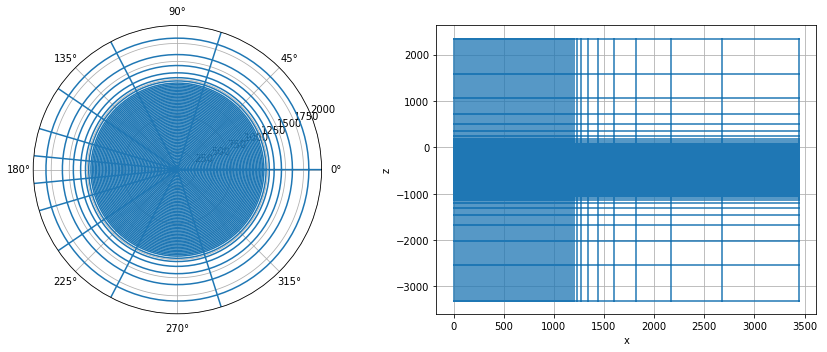

In [8]:
fig = plt.figure(figsize=(12, 5))
ax0 = plt.subplot(121, projection='polar')
ax1 = plt.subplot(122)

ax0.set_rlim([0.,2e3])

cylmesh.plotGrid(ax=[ax0, ax1])

In [9]:
cylsrc = casingSim.sources.DownHoleTerminatingSrc(
    modelParameters=cyl_model, meshGenerator=cyl_mesh_gen
)

In [10]:
cylsrc.validate()

True

(0.0, 1500.0)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


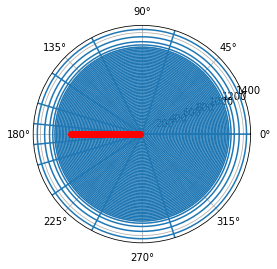

In [11]:
ax = plt.subplot(111, projection='polar')
cylmesh.plotGrid(ax=ax, slice='z')
ax.plot(cylmesh.gridFx[cylsrc.surface_wire,1], cylmesh.gridFx[cylsrc.surface_wire,0], 'ro')
ax.set_rlim([0., 1500.])

(-1.0, 2.0)

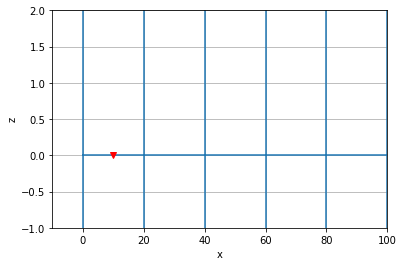

In [12]:
fig, ax = plt.subplots(1, 1)
cylmesh.plotGrid(ax=ax, slice='theta')
cylsrc.plot(ax=ax)

ax.set_xlim([-10., 100.])
ax.set_ylim([-1., 2.])

In [13]:
src_bx = -np.unique(cylmesh.gridFz[cylsrc.surface_electrode, 0])

In [14]:
cs = 10. 
cart_mesh_gen = casingSim.TensorMeshGenerator(
    modelParameters = cart_model, 
    csx = 20., 
    csy = 20., 
    csz = 20., 
    domain_x = (cart_model.src_a[0] - cart_model.src_b[0]) + cyl_mesh_gen.csx, # want a cell center at 0, 1000
    domain_y = 60.,
    pfx = cyl_mesh_gen.pfx,
    pfy = cyl_mesh_gen.pfx,
    pfz = cyl_mesh_gen.pfz,
    npadx = 9,
    npady = 9,
    npadz = 9,
    nca = cyl_mesh_gen.nca,  # number of core cells above the air-earth interface
    ncb = cyl_mesh_gen.ncb,  # number of core cells below the borehole
    nch = 5  # number of extra cells in the horizontal direction 
)

In [15]:
cartmesh = cart_mesh_gen.mesh

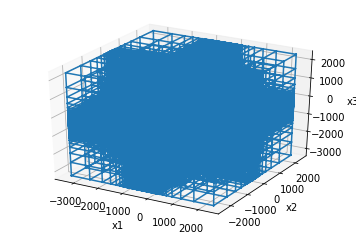

In [16]:
cartmesh.plotGrid()

In [17]:
cartsrc = casingSim.sources.DownHoleTerminatingSrc(
    modelParameters=cart_model, meshGenerator =cart_mesh_gen
)

In [18]:
cartsrc.validate()

True

(-40, 40.0)

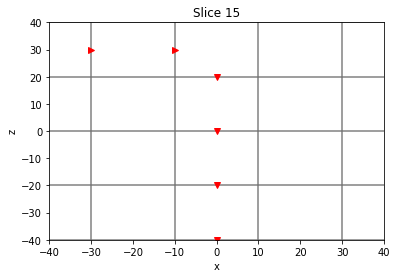

In [19]:
fig, ax = plt.subplots(1,1)
cartmesh.plotSlice(np.nan * np.ones(cartmesh.nC), grid=True, normal='Y', ax=ax)
cartsrc.plot(ax=ax)
ax.set_xlim([-40, 40.])
ax.set_ylim([-40, 40.])

# Load and plot the results

In [20]:
cylSimulation = casingSim.run.SimulationFDEM(
    directory=sim_dir_cyl, modelParameters=cyl_model, meshGenerator=cyl_mesh_gen, src=cylsrc
)
tensorSimulation = casingSim.run.SimulationFDEM(
    directory=sim_dir_tensor, modelParameters=cart_model, meshGenerator=cart_mesh_gen, src=cartsrc
)

In [21]:
# you can save the simulation file to run on a different machine

In [22]:
# cylSimulation.write_py(include2D=False, includeDC=False)
# tensorSimulation.write_py(include2D=False, includeDC=False)

In [23]:
# or run locally
if rerun is True: 
    cylFields = cylSimulation.run()
    tensorFields = tensorSimulation.run()

In [24]:
# or just load stored results and re-poulate the fields object
if rerun is False: 
    files = [sim_dir_cyl, sim_dir_tensor]
    
    for f in files:
        if not os.path.exists(f + os.path.sep + "fields.npy"):
            download = Utils.download(
                "https://storage.googleapis.com/simpeg/heagy_2018_emcyl/{}.tar.gz".format(f)
            )  
            tar = tarfile.open(download, "r:*")
            tar.extractall()
            tar.close()
    
    
    cyl_hfield = np.load('/'.join([sim_dir_cyl, 'fields.npy']))
    tensor_hfield = np.load('/'.join([sim_dir_tensor, 'fields.npy']))

    cylSimulation.prob.model = cylSimulation.physprops.model
    tensorSimulation.prob.model = tensorSimulation.physprops.model

    cylFields = cylSimulation.prob.fieldsPair(cylmesh, cylSimulation.survey)
    tensorFields = tensorSimulation.prob.fieldsPair(cartmesh, tensorSimulation.survey)
    cylFields[:,'hSolution'] = cyl_hfield
    tensorFields[:,'hSolution'] = tensor_hfield

In [25]:
# look at currents in a slice 
jcyl = cylFields[:,'j']
jtensor = tensorFields[:,'j']

In [26]:
# look at a slice along the plane of the source
jplt = casingSim.face3DthetaSlice(cylmesh, jcyl, theta_ind=5)

In [27]:
mesh2D = Mesh.CylMesh([cylmesh.hx, 1., cylmesh.hz], x0=cylmesh.x0)

(<matplotlib.collections.QuadMesh at 0xd1607e9b0>,
 <matplotlib.colorbar.Colorbar at 0xd1ad8a278>)

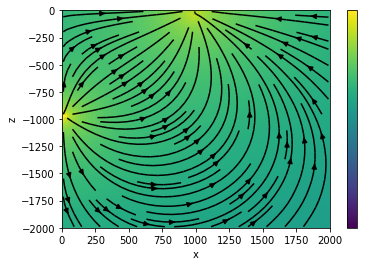

In [28]:
fig, ax = plt.subplots(1,1)
casingSim.plotFace2D(
    mesh2D,
    jplt, real_or_imag='real', ax=ax, range_x=np.r_[0., 2000.],
    range_y=np.r_[-2000., 0.], sample_grid=np.r_[20., 20.],
    log_scale=True
)

(-2000.0, 0.0)

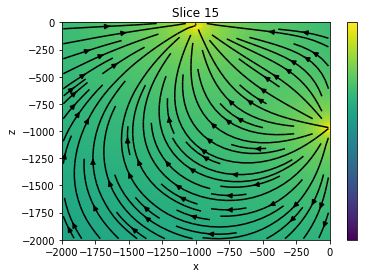

In [29]:
# here, the x-axis is reversed from the above image
fig, ax = plt.subplots(1,1)
plt.colorbar(cartmesh.plotSlice(
    jtensor.real, vType='F', view='vec', normal='Y', range_x=np.r_[-2000., 0.],
    range_y=np.r_[-2000., 0.], ax=ax, pcolorOpts = {'norm':LogNorm()}
)[0], ax=ax)
ax.set_xlim([-2000., 0.])
ax.set_ylim([-2000., 0.])

In [30]:
# compare lines of current density

jcyl_x = jcyl[:cylmesh.vnF[0]]
jtensor_x = jtensor[:cartmesh.vnF[0]]

In [31]:
cylgridFx = cylmesh.cartesianGrid('Fx')

## line through depth along the source line

In [32]:
# closest cartesian points
z_plt = cylmesh.vectorCCz[(cylmesh.vectorCCz < 0.) & (cylmesh.vectorCCz > -1500.)]
xyz0 = utils.ndgrid(np.r_[300.], np.r_[np.pi], z_plt)

# grab the nearest x-faces
indsx = Utils.closestPoints(cylmesh, xyz0, 'Fx')

cart_points = cylmesh.cartesianGrid('Fx')[indsx, :]

Pcart = cartmesh.getInterpolationMat(cart_points, 'Fx')

jx_cart = Pcart * jtensor
jx_cyl = -jcyl_x[indsx]

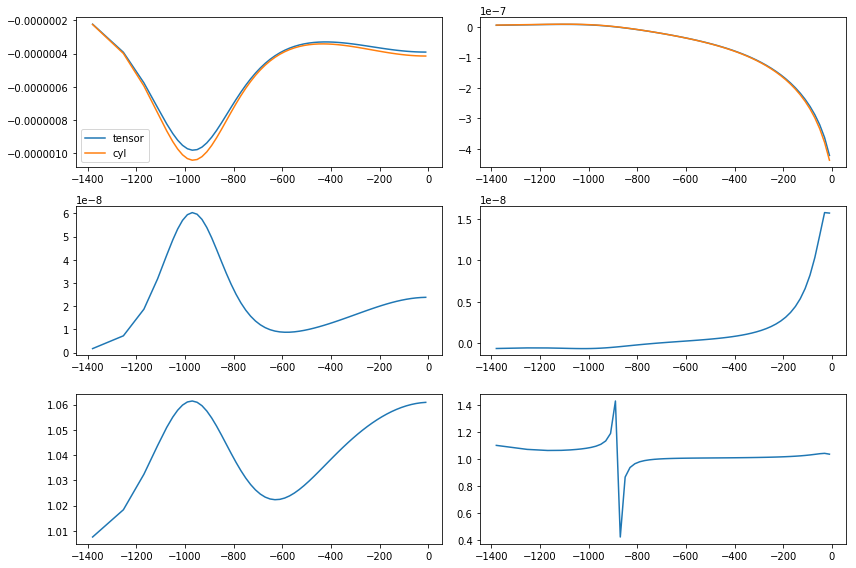

In [33]:
fig, ax = plt.subplots(3,2, figsize=(12,8))
ax = utils.mkvc(ax)
ax[0].plot(z_plt, jx_cart.real)
ax[0].plot(z_plt, jx_cyl.real)

ax[0].legend(['tensor', 'cyl'])

ax[1].plot(z_plt, jx_cart.real - jx_cyl.real)

ax[2].plot(z_plt, jx_cyl.real / jx_cart.real)

ax[3].plot(z_plt, jx_cart.imag)
ax[3].plot(z_plt, jx_cyl.imag)

ax[4].plot(z_plt, jx_cart.imag - jx_cyl.imag)

ax[5].plot(z_plt, jx_cyl.imag / jx_cart.imag)

plt.tight_layout()

## look at y-component along a line through depth ($\theta$ = $\pi/2$)

In [34]:
# closest cartesian points
z_plt = cylmesh.vectorCCz[(cylmesh.vectorCCz < 0.) & (cylmesh.vectorCCz > -1500.)]
xyz0 = utils.ndgrid(np.r_[200.], np.r_[np.pi/2.], z_plt)

# grab the nearest x-faces
inds_pi2 = Utils.closestPoints(cylmesh, xyz0, 'Fx')

cart_points = cylmesh.cartesianGrid('Fx')[inds_pi2, :]

Pcart = cartmesh.getInterpolationMat(cart_points, 'Fy')

jy_cart = Pcart * jtensor
jy_cyl = utils.sdiag(np.sin(cylmesh.gridFx[inds_pi2, 1])) * jcyl[inds_pi2]

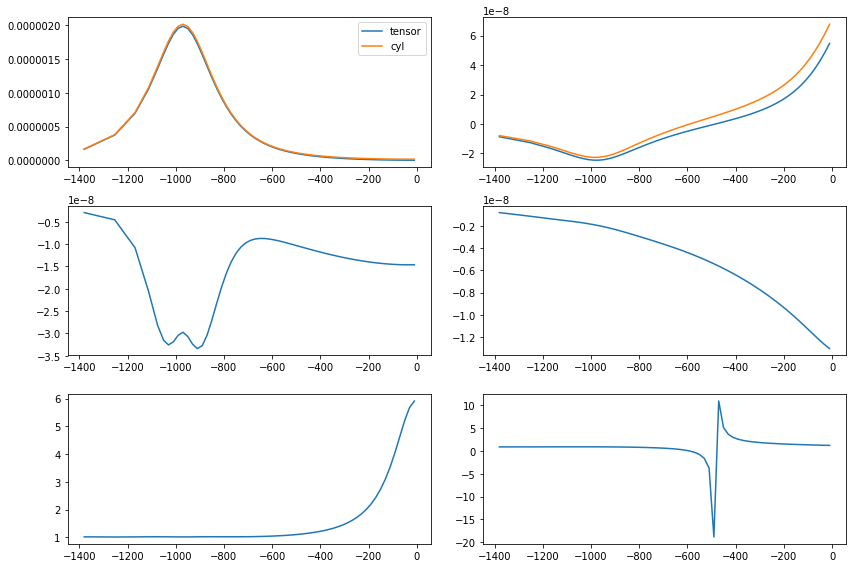

In [35]:
fig, ax = plt.subplots(3,2, figsize=(12,8))
ax = utils.mkvc(ax)
ax[0].plot(z_plt, jy_cart.real)
ax[0].plot(z_plt, jy_cyl.real)

ax[0].legend(['tensor', 'cyl'])

ax[1].plot(z_plt, jy_cart.real - jy_cyl.real)
ax[2].plot(z_plt, jy_cyl.real/jy_cart.real)

ax[3].plot(z_plt, jy_cart.imag)
ax[3].plot(z_plt, jy_cyl.imag)

ax[4].plot(z_plt, jy_cart.imag - jy_cyl.imag)
ax[5].plot(z_plt, jy_cyl.imag/jy_cart.imag)

plt.tight_layout()

In [36]:
def normalized_error(val1, val2):
    return np.linalg.norm(val1 - val2) / np.linalg.norm(0.5*(val1+val2))


In [37]:
# enforce real parts agree (low freq, so imag isn't contributing much)
assert normalized_error(jx_cart.real, jx_cyl.real) < 0.05
assert normalized_error(jy_cart.real, jy_cyl.real) < 0.05